In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os.path
import time
import requests
from matplotlib.dates import ConciseDateFormatter

# https://www.opendata.nhs.scot/datastore/dump/427f9a25-db22-4014-a3bc-893b68243055?bom=True


def haversine(lon1, lat1, lon2, lat2):
    # Calculate distances between lat/lon in miles.
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon / 2.0) ** 2

    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    dist = 3958 * dist  # 6367 for distance in KM for miles use 3958
    return dist

def commonPlotDecoration(ax):
    plt.xlabel('')
    ax.set_xlim(right=ax.get_xlim()[1] + 1)
    # ax.xaxis.set_major_formatter( ConciseDateFormatter( '%b' ) )

    plt.annotate('Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood',
                 (0, 0), (20, -50), xycoords='axes fraction',
                 textcoords='offset points', va='top',
                 fontsize=8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

def get_file(url,local_filename):
    #local_filename = url.split('/')[-1]
    r = requests.get(url)
    open(local_filename, 'wb').write(r.content)
    return

In [2]:
datazoneToInterZone = pd.read_csv('scotland-datazone-to-interzone.csv');

# QS603SC
#https://www.scotlandscensus.gov.uk/ods-web/standard-outputs.html?year=2011&table=QS603SC&tableDescription=Economic%20activity%20-%20Full-time%20students
studentPop = pd.read_csv('scotland_student_pop_SNS2011.csv');
studentPop = studentPop.rename(columns={'All full-time students aged 16 to 74': 'studentPop'})

#QS102SC table density converted to IZ
izDensity = pd.read_csv('scotland-iz-density.csv')
restricted = pd.read_csv('currentRestrictionScotland.csv')
izNames = pd.read_csv('scotland-iz.csv')
izCentroids = pd.read_csv('scotland-iz-centroids.csv')
HE_centroids = pd.read_csv('./learning-providers-plus.csv')

weeklyCases =  pd.read_csv('scotland_weekly_cases_iz.csv', thousands=',');
#weeklyCases =  pd.read_csv('scotland-iz-cases-from-aug.csv', thousands=',');

# # Get the latest case data from gov.uk
filename = './scotland-daily-council.csv'
# # if the file doesn't exist or it is more than 24 hours old
if not os.path.isfile(filename) or \
        (time.time() - os.path.getmtime(filename)) / (60 * 60) > 24:
    url = "https://www.opendata.nhs.scot/dataset/b318bddf-a4dc-4262-971f-0ba329e09b87/resource/427f9a25-db22-4014-a3bc-893b68243055/download/trend_ca_20201107.csv"
    get_file(url,filename)

#https://www.opendata.nhs.scot/dataset/b318bddf-a4dc-4262-971f-0ba329e09b87/resource/427f9a25-db22-4014-a3bc-893b68243055/download/trend_ca_20201107.csv
dailyCasesByCouncil = pd.read_csv('scotland-daily-council.csv')
dailyCasesByCouncil = pd.merge(left=dailyCasesByCouncil,right=restricted,left_on='CA',right_on='CA')
dailyCasesByCouncil['Date']=pd.to_datetime(dailyCasesByCouncil['Date'],format='%Y%m%d')

councilPop=pd.merge(left=izDensity,right=izNames,  left_on='InterZone', right_on='IntZone')
councilPop=councilPop.groupby('CA').sum()
councilPop=councilPop[['All people','Area (hectares)']].reset_index()
dailyCasesByCouncil=pd.merge(left=dailyCasesByCouncil,right=councilPop,left_on='CA',right_on='CA')

weeklyCases['dateEnd']=pd.to_datetime(weeklyCases['dateEnd'])
weeklyCases['dateStart']=pd.to_datetime(weeklyCases['dateStart'])
#Replace the obfuscated 1-4, with midpoint 2.5
weeklyCases['cases']=pd.to_numeric(weeklyCases['cases'].replace(to_replace='1-4',value=2.5))



simd=pd.read_csv('simd_zones.csv',thousands=',')
simd['simdBinned'] = pd.cut(simd[' Overall_SIMD16_rank '],bins=[0, 1395, 2790, 4185, 5580, 6976],labels=[1,2,3,4,5])
simd = simd.groupby(['Council_area','Intermediate_Zone'],as_index=False).min()
# % Get student pop to IZ

izSimd = pd.read_csv('scotland-iz-simd.csv')
izSimd['simd12_percent']= izSimd['simd1_percent']+izSimd['simd2_percent']
izSimd['simd45_percent']= izSimd['simd4_percent']+izSimd['simd5_percent']

merged = pd.merge(left=datazoneToInterZone, right=studentPop, left_on='DataZone', right_on='DataZone')
studentPopIz = merged.groupby(['InterZone'])[['studentPop']].agg('sum')

weeklyCases = pd.merge(left=weeklyCases,right=izNames[['IntZone','IntZoneName','CAName']],left_on=['council','IZ'], right_on=['CAName', 'IntZoneName'])

#weeklyCases = pd.merge(left=weeklyCases,right=simd[['Intermediate_Zone','Council_area','simdBinned','sim1dPercent']],left_on=['council','IZ'], right_on=['Council_area', 'Intermediate_Zone'])
weeklyCases = pd.merge(left=weeklyCases,right=izDensity,left_on='IntZone',right_on='InterZone')

weeklyCases = pd.merge(left=weeklyCases,right=izSimd,left_on='IntZone',right_on='InterZone')
weeklyCases = pd.merge(left=weeklyCases,right=studentPopIz,left_on='IntZone',right_index=True)

weeklyCases = pd.merge(left=weeklyCases,right=restricted,left_on='council',right_on='council')

weeklyCases['studentPercent'] = weeklyCases['studentPop'] / weeklyCases['pop']
weeklyCases['casePer100k'] = 1e5*weeklyCases['cases'].div(weeklyCases['pop'], axis=0)




HE_lon = HE_centroids['LONGITUDE']
HE_lat = HE_centroids['LATITUDE']

# Calculate distances. NOTE: Using a for loop like this is a very slow way to do it
# but is generally more clear to read.
allDist = np.zeros((len(izCentroids.index), len(HE_centroids.index)))

for index, row in izCentroids.iterrows():
    this_iz_lon = row['longitude']
    this_iz_lat = row['latitude']

    theseDist = haversine(this_iz_lon, this_iz_lat, HE_lon, HE_lat)
    allDist[index,] = theseDist

#Calculate the distance to nearest university.
uni_distance = np.nanmin(allDist, axis=1)
closestUniIdx = np.nanargmin(allDist, axis=1)
uni_name = HE_centroids['PROVIDER_NAME'].iloc[closestUniIdx].values
izCentroids.insert(1, "uni_distance", uni_distance)
izCentroids.insert(1, "uni_name", uni_name)



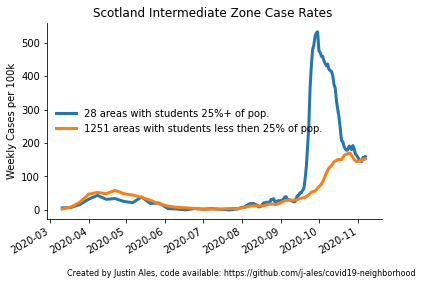

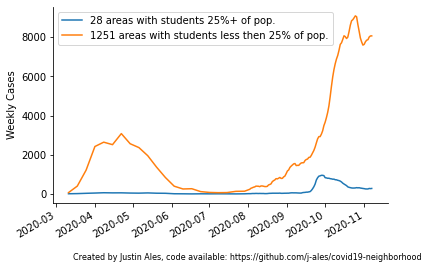

In [3]:

# Separate areas by student concentation.
popThresh = .25
highStudent = weeklyCases.loc[weeklyCases['studentPercent'] >= popThresh]
lowStudent = weeklyCases.loc[weeklyCases['studentPercent'] < popThresh]

highData= highStudent.groupby(['dateEnd'])[['casePer100k']].mean()
lowData= lowStudent.groupby(['dateEnd'])[['casePer100k']].mean()

numberHigh=len(highStudent['IntZone'].unique())
numberLow=len(lowStudent['IntZone'].unique())

fig, ax = plt.subplots(1, 1)
highData.plot(y='casePer100k',ax=ax,linewidth=3)
lowData.plot(y='casePer100k',ax=ax,linewidth=3)

plt.legend(['{} areas with students {:.0%}+ of pop.'.format(numberHigh,popThresh),
        '{} areas with students less then {:.0%} of pop.'.format(numberLow,popThresh)],
           frameon=False)
plt.ylabel('Weekly Cases per 100k')


plt.title('Scotland Intermediate Zone Case Rates ')
ax = plt.gca()
commonPlotDecoration(ax)

plt.show()


totalData = weeklyCases.groupby(['dateEnd'])[['cases']].sum()
highData= highStudent.groupby(['dateEnd'])[['cases']].sum()
lowData= lowStudent.groupby(['dateEnd'])[['cases']].sum()

fig, ax = plt.subplots(1, 1)
highData.plot(y='cases',ax=ax)
lowData.plot(y='cases',ax=ax)
#totalData.plot(y='cases',ax=ax)

plt.legend(['{} areas with students {:.0%}+ of pop.'.format(numberHigh,popThresh),
        '{} areas with students less then {:.0%} of pop.'.format(numberLow,popThresh)] )
plt.ylabel('Weekly Cases')
plt.xlabel('')
commonPlotDecoration(ax)
plt.show()

In [4]:
# restrictedAreas = weeklyCases.loc[weeklyCases['council'].isin(restricted['council'])]
# nonRestrictedAreas = weeklyCases.loc[~weeklyCases['council'].isin(restricted['council'])]
#
# numberResticted=len(restrictedAreas['IntZone'].unique())
# numberNonRestricted=len(nonRestrictedAreas['IntZone'].unique())
#
# restrictedAreas= restrictedAreas.groupby(['dateEnd'])[['casePer100k']].mean()
# nonRestrictedAreas= nonRestrictedAreas.groupby(['dateEnd'])[['casePer100k']].mean()
#
#
# fig, ax = plt.subplots(1, 1)
# restrictedAreas.plot(y='casePer100k',ax=ax,linewidth=3)
# nonRestrictedAreas.plot(y='casePer100k',ax=ax,linewidth=3)
# plt.title('Scotland Intermediate Zone Case Rates ')
#
# plt.legend(['{} areas in central belt under local restrictions'.format(numberResticted),
#         '{} areas outwith central belt'.format(numberNonRestricted)] )
#
# plt.ylabel('Weekly Cases per 100k')
# commonPlotDecoration(ax)
# plt.show()

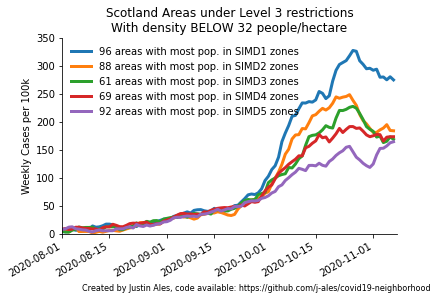

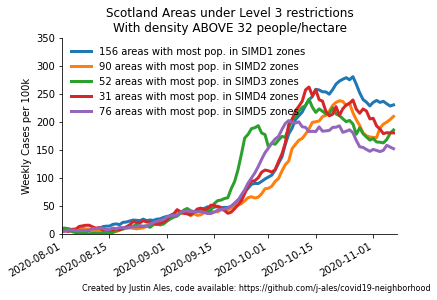

In [5]:
#[33,27.3,19.6]

iLevel = 3
medianDensity= weeklyCases.loc[(weeklyCases['level']==iLevel)]['Density'].median()
#lowThresh, highThresh,
popThresh = [ (0, medianDensity, f'Scotland Areas under Level {iLevel} restrictions\nWith density BELOW {medianDensity:.0f} people/hectare' ),
              (medianDensity, 10000,f'Scotland Areas under Level {iLevel} restrictions\nWith density ABOVE {medianDensity:.0f} people/hectare')]

for lowPopThresh, highPopThresh, titleText in popThresh:
    fig, ax = plt.subplots(1, 1)

    legendList = list()
    for iSimd in range(1,5+1):
        izWithSimd = weeklyCases.loc[(weeklyCases['simdMostPop']==iSimd)
                                    & (weeklyCases['level']==iLevel)
                                     & (weeklyCases['Density']<highPopThresh) & (weeklyCases['Density']>lowPopThresh)]
        #izWithSimd = weeklyCases.loc[(weeklyCases['simdMostPop']==iSimd) & (   weeklyCases['council'].isin(restricted['council']))]

        legendList.append(f'{len(izWithSimd["IntZone"].unique())} areas with most pop. in SIMD{iSimd} zones')

        izWithSimd= izWithSimd.groupby(['dateEnd'])[['casePer100k']].mean()
        izWithSimd.plot(y='casePer100k',ax=ax,linewidth=3)

    plt.xlim([dt.date(2020, 8, 1), weeklyCases['dateEnd'].max()-dt.timedelta(0)])

    plt.legend(legendList,frameon=False)
    plt.ylabel('Weekly Cases per 100k')
    commonPlotDecoration(ax)
    plt.title(titleText)
    #plt.title(f'Scotland Weekly Case Rate by SIMD')

    plt.ylim(0,300)
    plt.savefig(f'scotlandWeeklyBySimd{lowPopThresh:.0f}.png')
    plt.show()

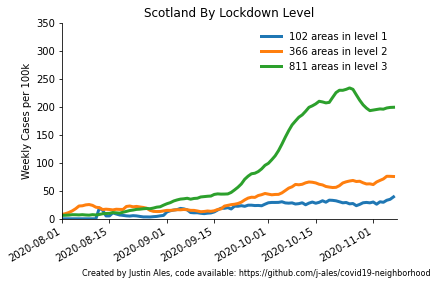

In [6]:
fig, ax = plt.subplots(1, 1)
#[33,27.3,19.6]

lowPopThresh = 0
highPopThresh = 10000

legendList = list()
for iLevel in range(1,3+1):
    izWithSimd = weeklyCases.loc[(weeklyCases['level']==iLevel)
                                 & (weeklyCases['Density']<highPopThresh) & (weeklyCases['Density']>lowPopThresh) ]
    #izWithSimd = weeklyCases.loc[(weeklyCases['simdMostPop']==iSimd) & (   weeklyCases['council'].isin(restricted['council']))]

    legendList.append(f'{len(izWithSimd["IntZone"].unique())} areas in level {iLevel}')

    izWithSimd= izWithSimd.groupby(['dateEnd'])[['casePer100k']].mean()
    izWithSimd.plot(y='casePer100k',ax=ax,linewidth=3)

plt.xlim([dt.date(2020, 8, 1), weeklyCases['dateEnd'].max()-dt.timedelta(0)])

plt.legend(legendList,frameon=False)
plt.ylabel('Weekly Cases per 100k')
commonPlotDecoration(ax)
plt.title('Scotland By Lockdown Level')
plt.ylim(0,300)

plt.show()

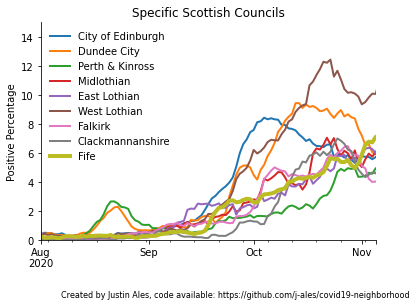

In [7]:
fig, ax = plt.subplots(1, 1)
#[33,27.3,19.6]

councilPopRes=pd.merge(left=councilPop,right=restricted,left_on="CA",right_on="CA")
popByLevel=councilPopRes.groupby('level').sum()
legendList = list()
councilList = ('City of Edinburgh','Dundee City','Perth & Kinross','Midlothian','East Lothian','West Lothian',
               'Falkirk','Clackmannanshire','Fife')
popList = councilPopRes.set_index('council')
for councilName  in councilList:
    thisLevel = dailyCasesByCouncil.loc[(dailyCasesByCouncil['CAName']==councilName)]

    legendList.append(councilName)


    # dailyPos = thisLevel.groupby(['Date'])[['DailyPositive']].sum().rolling(7).sum()
    # dailyRate = 1e5*dailyPos/popList['All people'].loc[councilName]

    dailyPositivePercent = thisLevel.groupby(['Date'])[['PositivePercentage']].mean().rolling(7).mean()
    dailyRate =  dailyPositivePercent

    if councilName=='Fife':
        dailyRate.plot(y='PositivePercentage', ax=ax, linewidth=4)
    else:
        dailyRate.plot(y='PositivePercentage', ax=ax, linewidth=2)

plt.xlim([dt.date(2020, 8, 1), dailyCasesByCouncil['Date'].max()-dt.timedelta(2)])

plt.legend(legendList,frameon=False)
plt.ylabel('Positive Percentage')
commonPlotDecoration(ax)
plt.title('Specific Scottish Councils')
#plt.ylim(0,300)
plt.ylim(0,15)

plt.show()

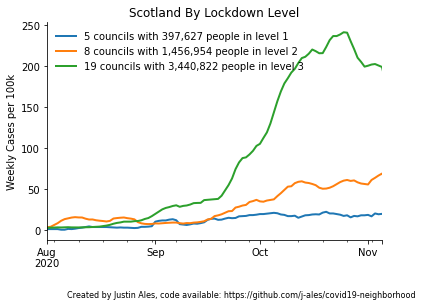

In [8]:
fig, ax = plt.subplots(1, 1)
#[33,27.3,19.6]

councilPopRes=pd.merge(left=councilPop,right=restricted,left_on="CA",right_on="CA")
popByLevel=councilPopRes.groupby('level').sum()
legendList = list()
for iLevel in range(1,3+1):
    thisLevel = dailyCasesByCouncil.loc[(dailyCasesByCouncil['level']==iLevel)]

    legendList.append(f'{sum(restricted["level"]==iLevel)} councils with {popByLevel["All people"].loc[iLevel]:,} people in level {iLevel}')

    dailyPos = thisLevel.groupby(['Date'])[['DailyPositive']].sum().rolling(7).sum()

    dailyRate = 1e5*dailyPos/popByLevel['All people'].loc[iLevel]

    dailyRate.plot(y='DailyPositive', ax=ax, linewidth=3)

plt.xlim([dt.date(2020, 8, 1), dailyCasesByCouncil['Date'].max()-dt.timedelta(2)])

plt.legend(legendList,frameon=False)
plt.ylabel('Weekly Cases per 100k')
commonPlotDecoration(ax)
plt.title('Scotland Cases/100k By Lockdown Level')
plt.ylim(0,300)
plt.savefig('scotlandWeeklyByLevel.png')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
#[33,27.3,19.6]

councilPopRes=pd.merge(left=councilPop,right=restricted,left_on="CA",right_on="CA")
popByLevel=councilPopRes.groupby('level').sum()
legendList = list()
for iLevel in range(1,3+1):
    weekly = pd.DataFrame()
    thisLevel = dailyCasesByCouncil.loc[(dailyCasesByCouncil['level']==iLevel)]

    legendList.append(f'{sum(restricted["level"]==iLevel)} councils with {popByLevel["All people"].loc[iLevel]:,} people in level {iLevel}')

    weekly = thisLevel.groupby(['Date'])[['TotalTests']].sum().rolling(7).sum()
    weekly['PositivesTests'] = thisLevel.groupby(['Date'])[['PositiveTests']].sum().rolling(7).sum()

    dailyRate = 100*weekly['PositivesTests'].div(weekly['TotalTests'])

    dailyRate.plot(y='DailyPositive', ax=ax, linewidth=3)

plt.xlim([dt.date(2020, 8, 1), dailyCasesByCouncil['Date'].max()-dt.timedelta(2)])

plt.legend(legendList,frameon=False)
plt.ylabel('Positive Test Percentage')
commonPlotDecoration(ax)
plt.title('Scotland Positive Test Rate By Lockdown Level')
plt.ylim(0,10)
plt.savefig('scotlandWeeklyPercentByLevel.png')

plt.show()

True


In [21]:
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

if (not isnotebook()):
    import imgkit

import tableTemplate as tt

maxDate = weeklyCases['dateEnd'].max()
#= dailyCasesByCouncil.groupby(['CA','Date'])[['DailyPositive']].sum()
lag = 2;
#dailyCasesByCouncil.reset_index(inplace=True)
t2=dailyCasesByCouncil['Date'].max()-dt.timedelta(lag)
t1=dailyCasesByCouncil['Date'].max()-dt.timedelta(lag+7)
dailyCasesByCouncil.set_index(['Date'],inplace=True)

thisWeek=dailyCasesByCouncil.loc[pd.date_range(t1,t2)].groupby('CA').sum()['DailyPositive']
lastWeek=dailyCasesByCouncil.loc[pd.date_range(t1-dt.timedelta(7),t2-dt.timedelta(7))].groupby('CA').sum()['DailyPositive']
thisWeekTests=dailyCasesByCouncil.loc[pd.date_range(t1,t2)].groupby('CA').sum()['TotalTests']
lastWeekTests=dailyCasesByCouncil.loc[pd.date_range(t1-dt.timedelta(7),t2-dt.timedelta(7))].groupby('CA').sum()['TotalTests']
# thisWeekPosPerc=dailyCasesByCouncil.loc[pd.date_range(t1,t2)].groupby('CA').mean()['PositivePercentage']
# lastWeekPosPerc=dailyCasesByCouncil.loc[pd.date_range(t1-dt.timedelta(7),t2-dt.timedelta(7))].groupby('CA').mean()['PositivePercentage']

dailyCasesByCouncil.reset_index(inplace=True)


thisWeekPosPerc =100*thisWeek/thisWeekTests
lastWeekPosPerc = 100*lastWeek/lastWeekTests
councilTable = pd.DataFrame({'thisWeekCase': thisWeek,
                             'lastWeekCase': lastWeek,
                             'caseDiff': (thisWeek-lastWeek)})
councilTable = pd.merge(left=councilTable,right=restricted,left_on='CA',right_on='CA')
councilTable=pd.merge(left=councilTable,right=councilPop,left_on='CA',right_on='CA')

councilTable['thisWeekRate'] = 1e5*councilTable['thisWeekCase'].div(councilTable['All people'])
councilTable['lastWeekRate'] = 1e5*councilTable['lastWeekCase'].div(councilTable['All people'])
councilTable['rateDiff'] =councilTable['thisWeekRate']-councilTable['lastWeekRate']

councilTable.sort_values('thisWeekRate',ascending=False,inplace=True)
councilTable['rank']=np.arange(32)+1
councilTable=councilTable[['rank','council','level','lastWeekRate','thisWeekRate','rateDiff','lastWeekCase','thisWeekCase','caseDiff']]

di = {'rank': 'Rank',
      'council': 'Local Authority',
      'level':   'Restriction Level',
      'thisWeekCase': 'Cases this week',
      'lastWeekCase': 'Cases last week',
      'caseDiff': 'Cases Difference',
      'thisWeekRate': 'Cases per 100k pop',
      'lastWeekRate': 'Prev. cases/100k',
      'rateDiff': 'Rate Difference',
     }
councilTable.rename(di,axis=1,inplace=True)
pd.set_option('precision',2)
lastLevel4=np.where(councilTable['Cases per 100k pop']>300)[0]
if lastLevel4.size>0:
    lastLevel4 =lastLevel4[-1]+1
else:
    lastLevel4=0
lastLevel3=np.where(councilTable['Cases per 100k pop']>150)[0][-1]+1
lastLevel2=np.where(councilTable['Cases per 100k pop']>=75)[0][-1]+1

fileModString =maxDate.strftime('%b-%d-%Y')
if (not isnotebook()):
    header='<b>Scotland councils ordered by cases per 100k population for 7 days ending ' + fileModString + '</b><br><br>'
    #html=(top30.to_html(formatters={'Number of Cases': '{:,.0f}'.format, 'Cases per 100k pop': '{:,.0f}'.format, 'Student Percentage': '{:,.0f}%'.format},index=False))
    html=(councilTable.to_html(formatters={
        'Cases this week': '{:,.0f}'.format,
        'Cases last week': '{:,.0f}'.format,
        'Restriction Level': '{:,.0f}'.format,
        },index=False))
    footer = '<br>Colors Scot.gov indicator cutoffs: Purple=4,Red=3,Orange=2,Green=1, Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood'

    imgkit.from_string( tt.rankColorCSS(lastLevel4,lastLevel3,lastLevel2,32)+header+html+footer,'councilRanks.jpg',options={'quality':30})
else:
    display(councilTable)

#Now make the table for % positive tests


thisWeekPosPerc = 100*thisWeek/thisWeekTests
lastWeekPosPerc = 100*lastWeek/lastWeekTests
councilTable = pd.DataFrame({'thisWeekPerc': thisWeekPosPerc,
                             'lastWeekPerc': lastWeekPosPerc,
                             'percDiff': (thisWeekPosPerc-lastWeekPosPerc)})
councilTable = pd.merge(left=councilTable,right=restricted,left_on='CA',right_on='CA')
councilTable=pd.merge(left=councilTable,right=councilPop,left_on='CA',right_on='CA')

councilTable.sort_values('thisWeekPerc',ascending=False,inplace=True)
councilTable['rank']=np.arange(32)+1
councilTable=councilTable[['rank','council','level','lastWeekPerc','thisWeekPerc','percDiff']]

di = {'rank': 'Rank',
      'council': 'Local Authority',
      'level':   'Restriction Level',
      'thisWeekPerc': 'Postive Test Rate This Week',
      'lastWeekPerc': 'Postive Test Rate Last Week',
      'percDiff': 'Difference',
     }
councilTable.rename(di,axis=1,inplace=True)
pd.set_option('precision',2)
lastLevel4=np.where(councilTable['Postive Test Rate This Week']>10)[0]
if lastLevel4.size>0:
    lastLevel4 =lastLevel4[-1]+1
else:
    lastLevel4=0
lastLevel3=np.where(councilTable['Postive Test Rate This Week']>5)[0][-1]+1
lastLevel2=np.where(councilTable['Postive Test Rate This Week']>=3)[0][-1]+1

fileModString =maxDate.strftime('%b-%d-%Y')
if (not isnotebook()):
    header='<b>Scotland councils ordered by cases per 100k population for 7 days ending ' + fileModString + '</b><br><br>'
    #html=(top30.to_html(formatters={'Number of Cases': '{:,.0f}'.format, 'Cases per 100k pop': '{:,.0f}'.format, 'Student Percentage': '{:,.0f}%'.format},index=False))
    html=(councilTable.to_html(formatters={
        'Postive Test Rate This Week': '{:,.1f}%'.format,
        'Postive Test Rate Last Week': '{:,.1f}%'.format,
        'Difference': '{:,.1f}%'.format,
        'Restriction Level': '{:,.0f}'.format,
        },index=False))
    footer='<br>Colors Scot.gov indicator cutoffs: Purple=4,Red=3,Orange=2,Green=1, Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood'

    imgkit.from_string( tt.rankColorCSS(lastLevel4,lastLevel3,lastLevel2,32)+header+html+footer,'councilPercentRanks.jpg',options={'quality':30})
else:
    display(councilTable)






,Rank,Local Authority,Restriction Level,Prev. cases/100k,Cases per 100k pop,Rate Difference,Cases last week,Cases this week,Cases Difference
30,1,Glasgow City,3.0,394.95,369.49,-25.45,2343,2192,-151
16,2,South Lanarkshire,3.0,408.18,346.05,-62.14,1281,1086,-195
31,3,North Lanarkshire,3.0,360.35,311.49,-48.86,1217,1052,-165
22,4,Renfrewshire,3.0,274.43,285.86,11.43,480,500,20
27,5,East Dunbartonshire,3.0,288.50,278.98,-9.52,303,293,-10
4,6,East Renfrewshire,3.0,319.08,267.18,-51.89,289,242,-47
23,7,West Dunbartonshire,3.0,238.10,244.71,6.61,216,222,6
24,8,West Lothian,3.0,246.12,214.71,-31.41,431,376,-55
15,9,South Ayrshire,3.0,185.29,207.45,22.16,209,234,25
2,10,East Ayrshire,3.0,283.46,175.94,-107.52,348,216,-132


In [10]:
from IPython.display import display, HTML, Markdown
import imgkit
from tableTemplate import css

maxDate = weeklyCases['dateEnd'].max()
mostRecentWeek = weeklyCases.loc[weeklyCases['dateEnd']==maxDate]
mostRecentWeek = pd.merge(left=mostRecentWeek,right=izCentroids[['IntZone','uni_name','uni_distance']],left_on=['IntZone'], right_on=['IntZone'])

mostRecentWeek = mostRecentWeek.sort_values('casePer100k',ascending=False)
mostRecentWeek['studentPercent'] = 100*mostRecentWeek['studentPercent']

top30 = mostRecentWeek.head(30)

top30 = top30[
    # ['council','IZ','cases','casePer100k','studentPercent',
    #  'uni_distance','uni_name']]
['council', 'IZ', 'level','cases', 'casePer100k',
 'Density',
 'simd12_percent','simd45_percent']]

top30[['simd12_percent','simd45_percent']]=100*top30[['simd12_percent','simd45_percent']]
 #'simd1_percent','simd2_percent','simd3_percent','simd4_percent','simd5_percent']]
#
# di = {'IZ': 'Neighbourhood',
#       'council': 'Local Authority',
#       'cases': 'Number of Cases',
#       'casePer100k': 'Cases per 100k pop',
#       'studentPercent': 'Student Percentage',
#       'uni_distance': 'Miles to Univeristy',
#       'uni_name': 'Nearest University'
#      }
di = {'IZ': 'Neighbourhood',
      'council': 'Local Authority',
      'cases': 'Number of Cases',
      'casePer100k': 'Cases per 100k pop',
      'Density': 'Persons per Hectare',
      'simd12_percent': '% in most deprived (SIMD1/2)',
      'simd45_percent': '% in least deprived (SIMD4/5)',
     }
top30.rename(di,axis=1,inplace=True)

pd.set_option('precision',2)

fileModString =maxDate.strftime('%b-%d-%Y')

header='<b>Scotland 30 Intermediate Zones with highest cases per 100k population for 7 days ending ' + fileModString + '</b><br><br>'
#html=(top30.to_html(formatters={'Number of Cases': '{:,.0f}'.format, 'Cases per 100k pop': '{:,.0f}'.format, 'Student Percentage': '{:,.0f}%'.format},index=False))
html=(top30.to_html(formatters={
    'Number of Cases': '{:,.0f}'.format,
    '% in most deprived (SIMD1/2)': '{:,.0f}%'.format,
    '% in least deprived (SIMD4/5)': '{:,.0f}%'.format,
    'level': '{:,.0f}'.format,
    },index=False))
footer='<br>Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood'

imgkit.from_string(css+header+html+footer,'highestCaseRate.jpg',options={'quality':30})

ModuleNotFoundError: No module named 'imgkit'

In [ ]:
from IPython.display import display, HTML, Markdown
import imgkit
import tableTemplate as tt

maxDate = weeklyCases['dateEnd'].max()-dt.timedelta(0)
mostRecentWeek = weeklyCases.loc[weeklyCases['dateEnd']==maxDate]


lastWeek = weeklyCases.loc[weeklyCases['dateEnd']==(maxDate-dt.timedelta(7))]
mostRecentWeek = mostRecentWeek.reset_index()
lastWeek = lastWeek.reset_index()

# mostRecentWeek = pd.merge(left=mostRecentWeek,right=izCentroids[['IntZone','uni_name','uni_distance']],left_on=['IntZone'], right_on=['IntZone'])
mostRecentWeek['casesLastWeek']=np.nan
mostRecentWeek['casePer100kLastWeek']=np.nan

for index, row in mostRecentWeek.iterrows():
    # print(row)
    # print(lastWeek.loc[lastWeek['IZCode'] == row['IZCode']])


    lwIdx = np.where(lastWeek['IZCode'] == row['IZCode'])[0]
    if (lwIdx.size == 0):
        continue
    else:
        lwIdx = lwIdx[0]
    mostRecentWeek.loc[index,'casesLastWeek'] = lastWeek.loc[lwIdx,'cases']
    mostRecentWeek.loc[index,'casePer100kLastWeek'] = lastWeek.loc[lwIdx,'casePer100k']

#mostRecentWeek[['casesLastWeek','casePer100kLastWeek']].iloc[index]=

mostRecentWeek['caseDiff']= mostRecentWeek['cases']-mostRecentWeek['casesLastWeek']
mostRecentWeek['casePer100kDiff']= mostRecentWeek['casePer100k']-mostRecentWeek['casePer100kLastWeek']

mostRecentWeek = mostRecentWeek.sort_values('casePer100kDiff',ascending=False)

top30 = mostRecentWeek

top30 = top30.loc[:,
    # ['council','IZ','cases','casePer100k','studentPercent',
    #  'uni_distance','uni_name']]
['council', 'IZ', 'level','cases','caseDiff', 'casePer100k','casePer100kDiff',
 'Density',
 'simd12_percent','simd45_percent']]

top30.loc[:,['simd12_percent','simd45_percent']]=100*top30.loc[:,['simd12_percent','simd45_percent']]

di = {'IZ': 'Neighbourhood',
      'council': 'Local Authority',
      'cases': 'Number of Cases',
      'casePer100k': 'Cases per 100k pop',
      'caseDiff': 'Case change from last week',
      'casePer100kDiff': 'Rate change from last week',
      'Density': 'Persons per Hectare',
      'simd12_percent': '% in most deprived (SIMD1/2)',
      'simd45_percent': '% in least deprived (SIMD4/5)',
     }
top30.rename(di,axis=1,inplace=True)


top30Increase = top30.head(30)

top30Decrease = top30.sort_values('Rate change from last week',ascending=True)
top30Decrease = top30Decrease.head(30)

pd.set_option('precision',2)

fileModString =maxDate.strftime('%b-%d-%Y')

header='<b>Scotland 30 Intermediate Zones with largest weekly increase in weekly cases per 100k population as of ' + fileModString + '</b><br><br>'
#html=(top30.to_html(formatters={'Number of Cases': '{:,.0f}'.format, 'Cases per 100k pop': '{:,.0f}'.format, 'Student Percentage': '{:,.0f}%'.format},index=False))
html=(top30Increase.to_html(formatters={
    'Number of Cases': '{:,.0f}'.format,
    '% in most deprived (SIMD1/2)': '{:,.0f}%'.format,
    '% in least deprived (SIMD4/5)': '{:,.0f}%'.format,
    'level': '{:,.0f}'.format,
    },index=False))
footer='<br>Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood'

imgkit.from_string(tt.increaseCSS+header+html+footer,'increase.jpg',options={'quality':30})


header='<b>Scotland 30 Intermediate Zones with largest decrease in weekly cases per 100k population as of ' + fileModString + '</b><br><br>'
#html=(top30.to_html(formatters={'Number of Cases': '{:,.0f}'.format, 'Cases per 100k pop': '{:,.0f}'.format, 'Student Percentage': '{:,.0f}%'.format},index=False))
html=(top30Decrease.to_html(formatters={
    'Number of Cases': '{:,.0f}'.format,
    '% in most deprived (SIMD1/2)': '{:,.0f}%'.format,
    '% in least deprived (SIMD4/5)': '{:,.0f}%'.format,
    'level': '{:,.0f}'.format,
    },index=False))
footer='<br>Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood'

imgkit.from_string(tt.decreaseCSS+header+html+footer,'decrease.jpg')